<a href="https://colab.research.google.com/github/SamuelBFG/ga-fading/blob/main/ShadowedKappaMu_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from scipy import special as sp
from scipy.stats import gaussian_kde
from scipy.io import loadmat
from sklearn.neighbors import KernelDensity
from scipy import special as sp

plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline

## Set up directories
paths = ['plots', 
            'plots/gen/', 
        ]
for i in paths:
    if not os.path.exists(i):
        os.makedirs(i)

## Data (dBm)

In [2]:
data_dBm = pd.read_csv('/content/P_dBm_out_LOS_Head_Indoor.txt', sep=" ", header=None).transpose().dropna().reset_index(drop=True)

In [3]:
data_dBm.describe()

,0
count,181144.000000
mean,-59.800541
std,6.614254
min,-101.912900
25%,-63.651613
50%,-59.441935
75%,-55.325806
max,-43.725806


In [4]:
data_dBm

,0
0,-49.058065
1,-49.151613
2,-49.151613
3,-49.151613
4,-49.245161
...,...
181139,-62.716129
181140,-62.529032
181141,-62.716129
181142,-62.622581


In [12]:
def dBm2mV(dBm):
  
  mV =  np.power(10, (dBm + 46.9897)/20)
  return mV

In [13]:
data_mV = dBm2mV(data_dBm)
globalMean = data_mV.mean()
data_mV = data_mV / globalMean
data_mV

,0
0,2.649921
1,2.621534
2,2.621534
3,2.621534
4,2.593451
...,...
181139,0.549958
181140,0.561933
181141,0.549958
181142,0.555913


## Genetic Algorithm with $\kappa$-$\mu$

### KDE Samples plot:

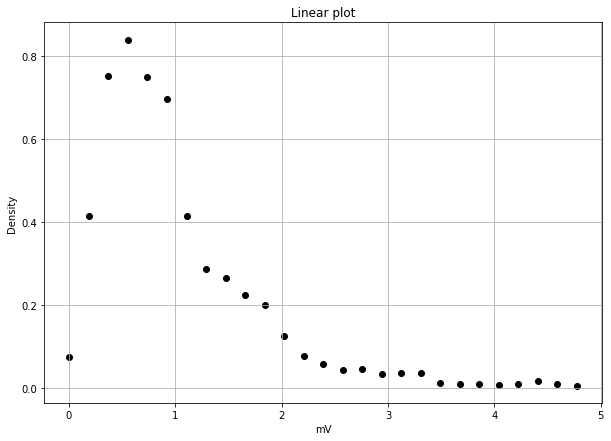

In [15]:
nExtractedSamples = 81
Xdata = np.linspace(data_mV.min(), data_mV.max(), nExtractedSamples).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=0.07).fit(data_mV.values.reshape(-1, 1))
logkde = kde.score_samples(Xdata)
Ydata = np.exp(logkde).reshape(-1,1)
plt.figure(figsize=(10,7))
plt.scatter(Xdata[::3], Ydata[::3], c='black')
plt.title('Linear plot')
plt.ylabel('Density')
plt.xlabel('mV')
plt.grid()
plt.show()

### MLE: $\kappa$-$\mu$ and Shadowed $\kappa$-$\mu$:

In [16]:
from scipy.special import gamma
import math

mle_kappa_mu = [0.0100000000000222, 0.794245863440659, 0.984845553504606]

mle_shadowed_kappa_mu = [2.50378514576399, 1.04171495240545, 1.52666133132221, 0.238939978717897]

mle_rice = [0.0260577235710763, 0.884270540895972]
rice_K = (mle_rice[0]**2) / (2*mle_rice[1]**2)
rice_omega = (mle_rice[0]**2) + (2*mle_rice[1]**2)

mle_nak = [0.631008863728655, 1.56440816925206]
nak_m = mle_nak[0]
nak_omega = mle_nak[1]

In [20]:
def computePDF(r, kappa, mu, omega):
  '''
  kappa-mu pdf.
  '''

  A = (2*mu * ((1 + kappa)**((mu+1)/2))) \
          /(np.sqrt(omega) * (kappa**((mu-1)/2)) * np.exp(mu * kappa))
  B = (r / np.sqrt(omega))**(mu)
  C = np.exp(-mu*(1+kappa) * (r/np.sqrt(omega))**2)
  D = sp.iv(mu-1, 2*mu * np.sqrt(kappa * (1+kappa)) * (r/np.sqrt(omega)))

  pdf = A * B * C * D
  return pdf

def shadowedKappaMuPDF(r, kappa, mu, omega, md):
  '''
  shadowed kappa-mu pdf.
  '''
  A = 2 * r**((2*mu) -1) / omega**(mu)
  B = (mu**mu * md**md * (1+kappa)**mu) / (sp.gamma(mu) * ((mu*kappa)+md)**md)
  C = np.exp((- mu * (1+kappa) * r**2) / omega)
  D = (mu**2) * kappa * (1+kappa) * (r**2)
  E = ((mu*kappa)+md) * omega
  F = sp.hyp1f1(md, mu, D / E)

  pdf = A * B * C * F
  return pdf

def kldiv(pVec1, pVec2):
  '''
  Kullback-Leibler divergence.
  '''
  KL = np.sum(pVec1*(np.log2(pVec1)-np.log2(pVec2)))
  return KL

def RAD(kldiv1, kldiv2):
  '''
  Resistor-Average Distance.
  '''
  RAD = 1/(1/kldiv1+1/kldiv2)
  return RAD


def fitness(X, Y, fitnessType, kappa, mu, omega):
  '''
  Fitness function (MSE/RAD) to determine how good a given solution is.
  '''
  if fitnessType == 'MSE':
    y_pred = computePDF(X, kappa, mu, omega)
    n = len(Y)
    cost = 1/n * sum(val**2 for val in (Y-y_pred))
    return 1/cost
  elif fitnessType == 'RAD':
    pVec1 = Y/np.sum(Y)
    pVec2 = computePDF(X, kappa, mu, omega)/np.sum(computePDF(X, kappa, mu, omega))
    KLD_1 = kldiv(pVec1, pVec2)
    KLD_2 = kldiv(pVec2, pVec1)
    cost = RAD(KLD_1, KLD_2)
    return 1/cost


def geneticAlgorithm(X, Y, mleResults):
  '''
  Evolutionary Loop
  '''
  solutions = []
  bestParams = []
  bestCriteria = 0
  bestGen = 0


  # Generate solutions (chromossomes)
  for s in range(nPopulation):
    solutions.append((random.uniform(0.01, 10), # kappa
                        random.uniform(0.1, 1.0), # mu
                        random.uniform(0.1, 1.0))) # r_hat^2

  # Evolutionary Loop
  for i in range(nMaxGen):
    rankedSolutions = []	
    for s in solutions:
      rankedSolutions.append( (fitness(X, Y, fitnessType, s[0],s[1],s[2]), s) )
    rankedSolutions.sort()
    rankedSolutions.reverse()
    
    print(f'=== Generation: {i} === ')
    print(f'Fitness: {rankedSolutions[0][0]}')
    print('Best individual:')
    print(f'Kappa: {rankedSolutions[0][1][0]}')
    print(f'Mu: {rankedSolutions[0][1][1]}')
    print(f'Omega: {rankedSolutions[0][1][2]}\n')

    plt.figure(figsize=((10,7)))
    plt.plot(20*np.log10(X), computePDF(X, rankedSolutions[0][1][0], rankedSolutions[0][1][1], rankedSolutions[0][1][2]), label='Predicted')
    plt.scatter(20*np.log10(X), Y, color='m', label='Real')
    plt.plot(20*np.log10(X), computePDF(X, mleResults[0], mleResults[1], mleResults[2]), label='Nidhi\'s MLE')
    plt.title(f'=== Generation: {i} === ')
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'$\rho=r/\hat{r}$')
    plt.ylabel('pdf')
    if savePlots: 
      plt.savefig(f'plots/gen/gen_{i}.png')
    
    if showPlots:
      plt.show()
      plt.clf()
    else: 
      plt.clf()

    # Keeping track the best params and generation:
    if rankedSolutions[0][0] > bestCriteria:
      bestCriteria = rankedSolutions[0][0]
      bestGen = i
      bestParams = rankedSolutions[0][1]

    # Stop Criterion: Fitness > 150 (TRIAL AND ERROR)
    # if rankedSolutions[0][0] > 152.8:
    #   print('='*10+'\n'+'Stopped by fitness criteria!\n'+'='*10+'\n')
    #   # print('='*10)
    #   # print('Stopped by fitness criteria!')
    #   # print('='*10)
    #   print('Best Fitness: {}\nBest Gen: {}'.format(bestCriteria, bestGen))
    #   print('Kappa: {}\nMu: {}\nOmega: {}'.format(bestParams[0],bestParams[1],bestParams[2]))
    #   break

    # Combine the best solutions and make a new solution of those combined solutions
    bestSolutions = rankedSolutions[:100]
    elements_kappa = []
    elements_mu = []
    elements_omega = [] 
    for s in bestSolutions:
      elements_kappa.append(s[1][0])
      elements_mu.append(s[1][1])
      elements_omega.append(s[1][2])

    newGen = []
    for _ in range(nPopulation):
      e1 = random.choice(elements_kappa) * random.uniform(0.975,1.025) # Mutation of 5%
      e2 = random.choice(elements_mu) * random.uniform(0.975,1.025) # Mutation of 5%
      e3 = random.choice(elements_omega) * random.uniform(0.975,1.025) # Mutation of 5%
      newGen.append((e1,e2,e3))

    solutions = newGen
    
    if i == nMaxGen-1:
      print('='*10+'\n'+'Max number of generations exceeded!\n'+'='*10+'\n')
      # print()
      # print('='*10)
      print('Best Fitness: {}\nBest Gen: {}'.format(bestCriteria, bestGen))
      print('Kappa: {}\nMu: {}\nOmega: {}'.format(bestParams[0],bestParams[1],bestParams[2]))

      return bestParams[0],bestParams[1],bestParams[2]

### $\kappa$-$\mu$ MLE plot:

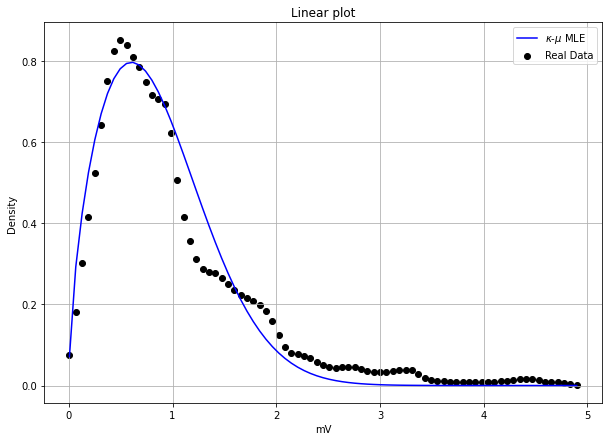

In [46]:
k_u_pdf = computePDF(Xdata, mle_kappa_mu[0], mle_kappa_mu[1], mle_kappa_mu[2])
plt.figure(figsize=(10,7))
plt.scatter(Xdata, Ydata, c='black', label='Real Data')
plt.plot(Xdata, k_u_pdf, c='blue', label=r'$\kappa$-$\mu$ MLE')
plt.title('Linear plot')
plt.ylabel('Density')
plt.xlabel('mV')
plt.legend()
plt.grid()
plt.show()

### GA: $\kappa$-$\mu$ (MSE) fit

In [22]:
### PARAMETERS
nMaxGen = 100
nPopulation = 1000
savePlots = False
showPlots = False
fitnessType = 'MSE'
# nAP = 'AP2'
kappa_hat, mu_hat, omega_hat = geneticAlgorithm(Xdata, Ydata, mle_kappa_mu)

=== Generation: 0 === 
Fitness: [307.35715335]
Best individual:
Kappa: 0.09894108532412162
Mu: 0.8396989041806885
Omega: 0.944531652114945

=== Generation: 1 === 
Fitness: [309.6284247]
Best individual:
Kappa: 0.10118828203525057
Mu: 0.7684476054186439
Omega: 0.9486679840952398

=== Generation: 2 === 
Fitness: [321.89714494]
Best individual:
Kappa: 0.10132542070714827
Mu: 0.7857302741372602
Omega: 0.9859027695727196

=== Generation: 3 === 
Fitness: [324.30683257]
Best individual:
Kappa: 0.05945151428545724
Mu: 0.8018284225997224
Omega: 0.9828219765032611

=== Generation: 4 === 
Fitness: [324.85145485]
Best individual:
Kappa: 0.057336054472141074
Mu: 0.7900969159278893
Omega: 0.9861759464652484

=== Generation: 5 === 
Fitness: [325.05085542]
Best individual:
Kappa: 0.054573883687465886
Mu: 0.7926260552990715
Omega: 0.986727107116343

=== Generation: 6 === 
Fitness: [325.0509373]
Best individual:
Kappa: 0.05369118770783353
Mu: 0.7910366180309373
Omega: 0.9847061387706695

=== Generation:

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

In [23]:
kappa_hat, mu_hat, omega_hat

(0.024319346229185544, 0.7944711715119114, 0.9839716206909839)

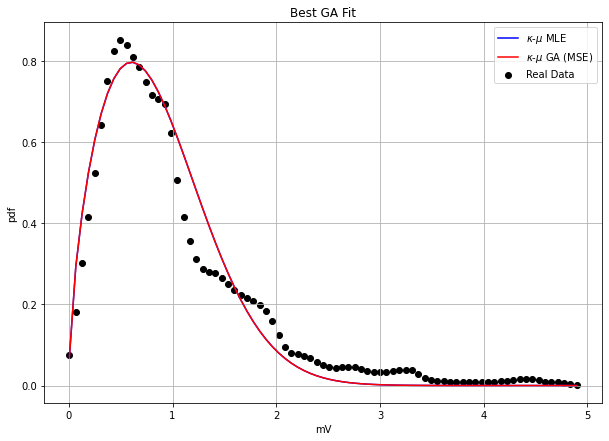

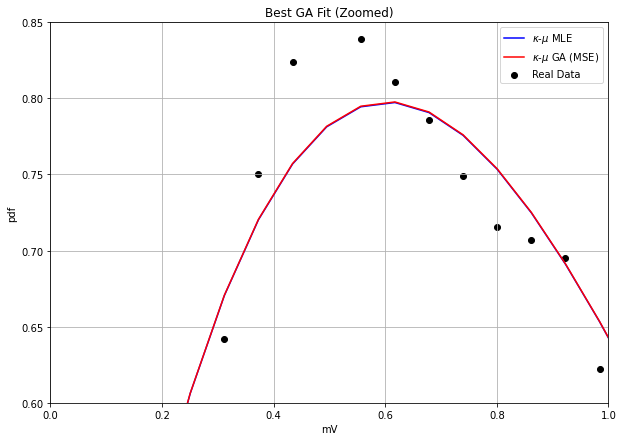

In [45]:
k_u_pdf = computePDF(Xdata, mle_kappa_mu[0], mle_kappa_mu[1], mle_kappa_mu[2])
plt.figure(figsize=((10,7)))
plt.scatter(Xdata, Ydata, c='black', label='Real Data')
plt.plot(Xdata, k_u_pdf, c='blue', label=r'$\kappa$-$\mu$ MLE')
plt.plot(Xdata, computePDF(Xdata, kappa_hat, mu_hat, omega_hat), label='$\kappa$-$\mu$ GA (MSE)', c='red')
plt.title(f'Best GA Fit')
plt.legend()
plt.grid(True)
plt.xlabel(r'mV')
plt.ylabel('pdf')
plt.show()

plt.figure(figsize=((10,7)))
plt.scatter(Xdata, Ydata, c='black', label='Real Data')
plt.plot(Xdata, k_u_pdf, c='blue', label=r'$\kappa$-$\mu$ MLE')
plt.plot(Xdata, computePDF(Xdata, kappa_hat, mu_hat, omega_hat), label='$\kappa$-$\mu$ GA (MSE)', c='red')
plt.title(f'Best GA Fit (Zoomed)')
plt.legend()
plt.grid(True)
plt.xlabel(r'mV')
plt.ylabel('pdf')
plt.ylim([.6, .85])
plt.xlim([0, 1])
plt.show()

### GA: $\kappa$-$\mu$ (RAD) fit

In [25]:
fitnessType = 'RAD'
# X, Y = getDensityEstimationSamples(pathAB_linear[nAP].dropna(), nExtractedSamples)
kappa_hat_rad, mu_hat_rad, omega_hat_rad = geneticAlgorithm(Xdata, Ydata, mle_kappa_mu)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply


=== Generation: 0 === 
Fitness: 7.659344517465317
Best individual:
Kappa: 1.4240217600222773
Mu: 0.5706801388436423
Omega: 0.888134686911024



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply


=== Generation: 1 === 
Fitness: 12.484335158177307
Best individual:
Kappa: 0.17393728690659968
Mu: 0.6817026517344316
Omega: 0.9319954218624886



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply


=== Generation: 2 === 
Fitness: 13.624792129561357
Best individual:
Kappa: 0.05710216873955773
Mu: 0.8147379785405846
Omega: 0.966597217314518

=== Generation: 3 === 
Fitness: 15.728474068521916
Best individual:
Kappa: 0.055256302820135106
Mu: 0.7296421901899017
Omega: 1.0194549826843886

=== Generation: 4 === 
Fitness: 16.582011470729974
Best individual:
Kappa: 0.05372600938722989
Mu: 0.7337095200246501
Omega: 1.0510650302673252

=== Generation: 5 === 
Fitness: 17.14884460574514
Best individual:
Kappa: 0.05419733954884094
Mu: 0.7362389970038832
Omega: 1.0737208812472412

=== Generation: 6 === 
Fitness: 17.57543342236977
Best individual:
Kappa: 0.055245865334943085
Mu: 0.7193707427603558
Omega: 1.0900572037138134

=== Generation: 7 === 
Fitness: 18.317154428001828
Best individual:
Kappa: 0.054997015987788965
Mu: 0.7316428863137091
Omega: 1.1230945896765638

=== Generation: 8 === 
Fitness: 18.875461235212683
Best individual:
Kappa: 0.055090845925003025
Mu: 0.7195308114436101
Omega: 1.14

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

In [22]:
(kappa_hat_rad, mu_hat_rad, omega_hat_rad)

(0.0471305312830924, 0.6796464474023944, 1.4102588005886854)

### Results plot

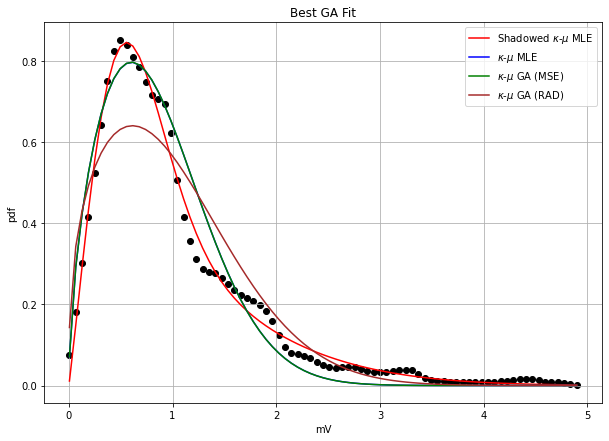

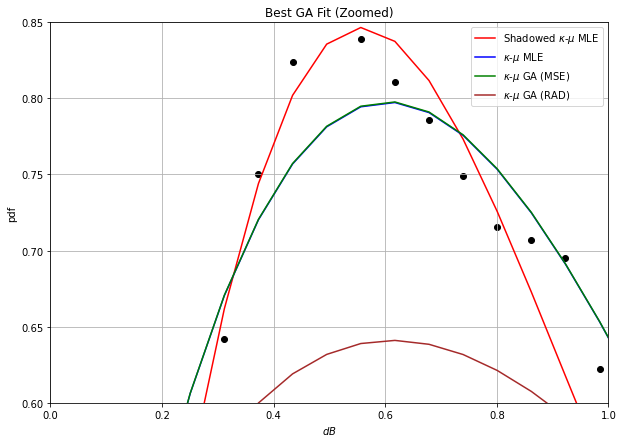

In [49]:
k_u_pdf = computePDF(Xdata, mle_kappa_mu[0], mle_kappa_mu[1], mle_kappa_mu[2])
shadowed_k_u_pdf = shadowedKappaMuPDF(Xdata, mle_shadowed_kappa_mu[0], mle_shadowed_kappa_mu[1], mle_shadowed_kappa_mu[2], mle_shadowed_kappa_mu[3])

plt.figure(figsize=((10,7)))
plt.scatter(Xdata, Ydata, c='black')
plt.plot(Xdata, shadowed_k_u_pdf, c='red', label=r'Shadowed $\kappa$-$\mu$ MLE')
plt.plot(Xdata, k_u_pdf, c='blue', label=r'$\kappa$-$\mu$ MLE')
plt.plot(Xdata, computePDF(Xdata, kappa_hat, mu_hat, omega_hat), label='$\kappa$-$\mu$ GA (MSE)', c='green')
plt.plot(Xdata, computePDF(Xdata, kappa_hat_rad, mu_hat_rad, omega_hat_rad), label='$\kappa$-$\mu$ GA (RAD)', c='brown')
plt.title(f'Best GA Fit')
plt.legend()
plt.grid(True)
plt.xlabel(r'mV')
plt.ylabel('pdf')
plt.show()

plt.figure(figsize=((10,7)))
plt.scatter(Xdata, Ydata, c='black')
plt.plot(Xdata, shadowed_k_u_pdf, c='red', label=r'Shadowed $\kappa$-$\mu$ MLE')
plt.plot(Xdata, k_u_pdf, c='blue', label=r'$\kappa$-$\mu$ MLE')
plt.plot(Xdata, computePDF(Xdata, kappa_hat, mu_hat, omega_hat), label='$\kappa$-$\mu$ GA (MSE)', c='green')
plt.plot(Xdata, computePDF(Xdata, kappa_hat_rad, mu_hat_rad, omega_hat_rad), label='$\kappa$-$\mu$ GA (RAD)', c='brown')
plt.title(f'Best GA Fit (Zoomed)')
plt.legend()
plt.grid(True)
plt.xlabel(r'$dB$')
plt.ylabel('pdf')
plt.ylim([.6, .85])
plt.xlim([0, 1])
plt.show()

### RAD/AIC Scores

In [27]:
# Scores - RAD
pVec1 = Ydata/np.sum(Ydata)
pVec2 = computePDF(Xdata, kappa_hat, mu_hat, omega_hat)/np.sum(computePDF(Xdata, kappa_hat, mu_hat, omega_hat))
KLD_1 = kldiv(pVec1, pVec2)
KLD_2 = kldiv(pVec2, pVec1)
rad_mse = RAD(KLD_1, KLD_2)

pVec2 = computePDF(Xdata, kappa_hat_rad, mu_hat_rad, omega_hat_rad)/np.sum(computePDF(Xdata, kappa_hat_rad, mu_hat_rad, omega_hat_rad))
KLD_1 = kldiv(pVec1, pVec2)
KLD_2 = kldiv(pVec2, pVec1)
rad_rad = RAD(KLD_1, KLD_2)

pVec2 = k_u_pdf/np.sum(k_u_pdf)
KLD_1 = kldiv(pVec1, pVec2)
KLD_2 = kldiv(pVec2, pVec1)
rad_mle_kappa_mu = RAD(KLD_1, KLD_2)

pVec2 = shadowed_k_u_pdf/np.sum(shadowed_k_u_pdf)
KLD_1 = kldiv(pVec1, pVec2)
KLD_2 = kldiv(pVec2, pVec1)
rad_mle_shadowed_kappa_mu = RAD(KLD_1, KLD_2)

# Scores - AIC

n = len(data_mV)
K = 3

# AIC MLE - KAPPA MU
sum = np.sum(np.log(computePDF(data_mV, mle_kappa_mu[0], mle_kappa_mu[1], mle_kappa_mu[2])))
AIC_mle_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

# AIC MLE - SHADOWED KAPPA MU
sum = np.sum(np.log(shadowedKappaMuPDF(data_mV, mle_shadowed_kappa_mu[0], mle_shadowed_kappa_mu[1], mle_shadowed_kappa_mu[2], mle_shadowed_kappa_mu[3])))
AIC_mle_shadowed_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

# AIC GENETIC ALGORITHM - FITNESS: MSE
sum = np.sum(np.log(computePDF(data_mV, kappa_hat, mu_hat, omega_hat)))
AIC_ga_mse = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)
  
# AIC GENETIC ALGORITHM - FITNESS: RAD
sum = np.sum(np.log(computePDF(data_mV, kappa_hat_rad, mu_hat_rad, omega_hat_rad)))
AIC_ga_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

rads = {'Methods':['Genetic Algorithm - KappaMu (MSE)', 'Genetic Algorithm - KappaMu (RAD)',\
                   'Maximum Likelihood Estimator - KappaMu', 'Maximum Likelihood Estimator - Shadowed KappaMu'],
		'Resistor Average Distance':[rad_mse, rad_rad, rad_mle_kappa_mu, rad_mle_shadowed_kappa_mu],
    'Akaike Information Criteria':[AIC_ga_mse[0], AIC_ga_rad[0], AIC_mle_kappa_mu[0], AIC_mle_shadowed_kappa_mu[0]]}

# Create DataFrame
df = pd.DataFrame(rads)
display(df.sort_values(by='Akaike Information Criteria').reset_index(drop=True))

,Methods,Resistor Average Distance,Akaike Information Criteria
0,Maximum Likelihood Estimator - Shadowed KappaMu,0.009950,313225.159357
1,Genetic Algorithm - KappaMu (RAD),0.045994,339767.607016
2,Maximum Likelihood Estimator - KappaMu,0.069296,380914.753628
3,Genetic Algorithm - KappaMu (MSE),0.069476,381235.211642


## Genetic Algorithm with Shadowed $\kappa-\mu$:

In [28]:
def shadowedKappaMuPDF(r, kappa, mu, omega, md):
  '''
  shadowed kappa-mu pdf.
  '''
  A = 2 * r**((2*mu) -1) / omega**(mu)
  B = (mu**mu * md**md * (1+kappa)**mu) / (sp.gamma(mu) * ((mu*kappa)+md)**md)
  C = np.exp((- mu * (1+kappa) * r**2) / omega)
  D = (mu**2) * kappa * (1+kappa) * (r**2)
  E = ((mu*kappa)+md) * omega
  F = sp.hyp1f1(md, mu, D / E)

  pdf = A * B * C * F
  return pdf

def fitness_sku(X, Y, fitnessType, kappa, mu, omega, md):
  '''
  Fitness function (MSE/RAD) to determine how good a given solution is.
  '''
  if fitnessType == 'MSE':
    y_pred = shadowedKappaMuPDF(X, kappa, mu, omega, md)
    n = len(Y)
    sum = []
    for val in (Y-y_pred):
      sum.append(val**2)
    sum = np.sum(sum)
    cost = 1/n * sum
    return 1/cost
  elif fitnessType == 'RAD':
    pVec1 = Y/np.sum(Y)
    pVec2 = shadowedKappaMuPDF(X, kappa, mu, omega, md)/np.sum(shadowedKappaMuPDF(X, kappa, mu, omega, md))
    KLD_1 = kldiv(pVec1, pVec2)
    KLD_2 = kldiv(pVec2, pVec1)
    cost = RAD(KLD_1, KLD_2)
    return 1/cost


def geneticAlgorithm_sku(X, Y, mleResults):
  '''
  Evolutionary Loop
  '''
  solutions = []
  bestParams = []
  bestCriteria = 0
  bestGen = 0


  # Generate solutions (chromossomes)
  for s in range(nPopulation):
    solutions.append((random.uniform(0.01, 10), # kappa
                        random.uniform(0.1, 1.0), # mu
                        random.uniform(0.1, 1.0), # r_hat^2
                        random.uniform(0.1, 1.0))) # md

  # Evolutionary Loop
  for i in range(nMaxGen):
    rankedSolutions = []	
    for s in solutions:
      rankedSolutions.append( (fitness_sku(X, Y, fitnessType, s[0],s[1],s[2],s[3]), s) )
    rankedSolutions.sort()
    rankedSolutions.reverse()
    
    print(f'=== Generation: {i} === ')
    print(f'Fitness: {rankedSolutions[0][0]}')
    print('Best individual:')
    print(f'Kappa: {rankedSolutions[0][1][0]}')
    print(f'Mu: {rankedSolutions[0][1][1]}')
    print(f'Omega: {rankedSolutions[0][1][2]}')
    print(f'Md: {rankedSolutions[0][1][3]}\n')

    plt.figure(figsize=((10,7)))
    plt.plot(20*np.log10(X), shadowedKappaMuPDF(X, rankedSolutions[0][1][0], rankedSolutions[0][1][1], rankedSolutions[0][1][2], rankedSolutions[0][1][3]), label='Predicted')
    plt.scatter(20*np.log10(X), Y, color='m', label='Real')
    plt.plot(20*np.log10(X), shadowedKappaMuPDF(X, mle_shadowed_kappa_mu[0], mle_shadowed_kappa_mu[1], mle_shadowed_kappa_mu[2], mle_shadowed_kappa_mu[3]), label='Nidhi\'s MLE')
    plt.title(f'=== Generation: {i} === ')
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'$\rho=r/\hat{r}$')
    plt.ylabel('pdf')
    if savePlots: 
      plt.savefig(f'plots/gen/gen_{i}.png')
    
    if showPlots:
      plt.show()
      plt.clf()
    else: 
      plt.clf()

    # Keeping track the best params and generation:
    if rankedSolutions[0][0] > bestCriteria:
      bestCriteria = rankedSolutions[0][0]
      bestGen = i
      bestParams = rankedSolutions[0][1]

    # Combine the best solutions and make a new solution of those combined solutions
    bestSolutions = rankedSolutions[:100]
    elements_kappa = []
    elements_mu = []
    elements_omega = [] 
    elements_md = [] 
    for s in bestSolutions:
      elements_kappa.append(s[1][0])
      elements_mu.append(s[1][1])
      elements_omega.append(s[1][2])
      elements_md.append(s[1][3])

    newGen = []
    for _ in range(nPopulation):
      e1 = random.choice(elements_kappa) * random.uniform(0.975,1.025) # Mutation of 5%
      e2 = random.choice(elements_mu) * random.uniform(0.975,1.025) # Mutation of 5%
      e3 = random.choice(elements_omega) * random.uniform(0.975,1.025) # Mutation of 5%
      e4 = random.choice(elements_md) * random.uniform(0.975,1.025) # Mutation of 5%
      
      newGen.append((e1,e2,e3,e4))

    solutions = newGen
    
    if i == nMaxGen-1:
      print('='*10+'\n'+'Max number of generations exceeded!\n'+'='*10+'\n')
      # print()
      # print('='*10)
      print('Best Fitness: {}\nBest Gen: {}'.format(bestCriteria, bestGen))
      print('Kappa: {}\nMu: {}\nOmega: {}\nMd: {}'.format(bestParams[0],bestParams[1],bestParams[2],bestParams[3]))

      return bestParams[0],bestParams[1],bestParams[2],bestParams[3]

### GA: Shadowed $\kappa-\mu$ (MSE) fit

In [29]:
fitnessType = 'MSE'
# X, Y = getDensityEstimationSamples(pathAB_linear[nAP].dropna(), nExtractedSamples)
kappa_hat_sku, mu_hat_sku, omega_hat_sku, md_hat_sku = geneticAlgorithm_sku(Xdata,Ydata, mle_shadowed_kappa_mu)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


=== Generation: 0 === 
Fitness: nan
Best individual:
Kappa: 6.773268080990648
Mu: 0.76161801519317
Omega: 0.16866953529436476
Md: 0.7376384538169947



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


=== Generation: 1 === 
Fitness: nan
Best individual:
Kappa: 6.859327601142026
Mu: 0.8545414483104811
Omega: 0.1727577443817141
Md: 0.9182645631120083



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


=== Generation: 2 === 
Fitness: 363.93105301699825
Best individual:
Kappa: 2.5191352255282773
Mu: 0.9427564382209945
Omega: 0.9384431583400187
Md: 0.7089278661887302



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


=== Generation: 3 === 
Fitness: 373.11775675996074
Best individual:
Kappa: 7.978981235150527
Mu: 0.944009987230209
Omega: 0.9582835963293093
Md: 0.7592280066575489

=== Generation: 4 === 
Fitness: 464.99073820273793
Best individual:
Kappa: 4.156884670933029
Mu: 0.9477385955199589
Omega: 0.9864000471516664
Md: 0.6283035256566956

=== Generation: 5 === 
Fitness: 462.780577443798
Best individual:
Kappa: 5.131943902190956
Mu: 0.9983590512186342
Omega: 0.988535716930655
Md: 0.6493591453655442

=== Generation: 6 === 
Fitness: 479.3520323504369
Best individual:
Kappa: 4.18503524438758
Mu: 0.9965343283644951
Omega: 0.9944917467593233
Md: 0.6466538297579023

=== Generation: 7 === 
Fitness: 543.6394905295849
Best individual:
Kappa: 4.219635848463301
Mu: 0.9836038833457175
Omega: 1.0531852281476473
Md: 0.6229210566648542

=== Generation: 8 === 
Fitness: 577.5092747133209
Best individual:
Kappa: 4.981164485090076
Mu: 1.0476370222960867
Omega: 1.0771606237842903
Md: 0.611709440529874

=== Generatio

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

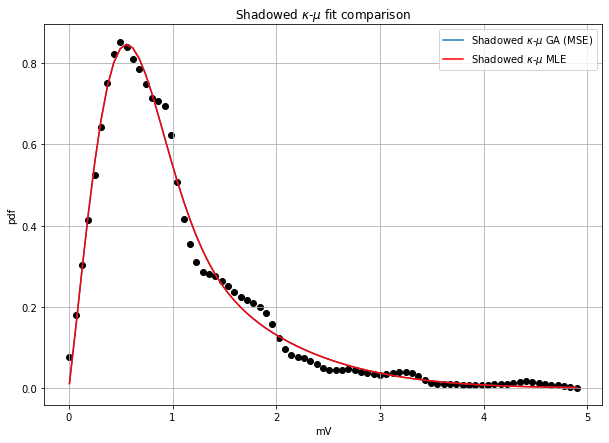

In [52]:
plt.figure(figsize=((10,7)))
plt.scatter(Xdata, Ydata, c='black')
plt.plot(Xdata, shadowedKappaMuPDF(Xdata, kappa_hat_sku, mu_hat_sku, omega_hat_sku, md_hat_sku), label='Shadowed $\kappa$-$\mu$ GA (MSE)')
plt.plot(Xdata, shadowed_k_u_pdf, label='Shadowed $\kappa$-$\mu$ MLE', c='red')
plt.title(f'Shadowed $\kappa$-$\mu$ fit comparison')
plt.legend()
plt.grid(True)
plt.xlabel(r'mV')
plt.ylabel('pdf')
plt.show()

In [33]:
(kappa_hat_sku, mu_hat_sku, omega_hat_sku, md_hat_sku)

(2.505572655154482,
 1.0426860603474026,
 1.5259038323122887,
 0.23911075684577013)

In [34]:
# Scores - RAD
pVec1 = Ydata/np.sum(Ydata)
pVec2 = shadowedKappaMuPDF(Xdata, kappa_hat_sku, mu_hat_sku, omega_hat_sku, md_hat_sku)\
/np.sum(shadowedKappaMuPDF(Xdata, kappa_hat_sku, mu_hat_sku, omega_hat_sku, md_hat_sku))
KLD_1 = kldiv(pVec1, pVec2)
KLD_2 = kldiv(pVec2, pVec1)
rad_ga_mse_sku = RAD(KLD_1, KLD_2)

## AIC Analysis

n = len(data_mV)
K = 3

# AIC MLE - KAPPA MU
sum = np.sum(np.log(computePDF(data_mV, mle_kappa_mu[0], mle_kappa_mu[1], mle_kappa_mu[2])))
AIC_mle_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

# AIC MLE - SHADOWED KAPPA MU
sum = np.sum(np.log(shadowedKappaMuPDF(data_mV, mle_shadowed_kappa_mu[0], mle_shadowed_kappa_mu[1], mle_shadowed_kappa_mu[2], mle_shadowed_kappa_mu[3])))
AIC_mle_shadowed_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

# AIC MLE - GA SHADOWED KAPPA MU
sum = np.sum(np.log(shadowedKappaMuPDF(data_mV, kappa_hat_sku, mu_hat_sku, omega_hat_sku, md_hat_sku)))
AIC_ga_shadowed_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

# AIC GENETIC ALGORITHM - FITNESS: MSE
sum = np.sum(np.log(computePDF(data_mV, kappa_hat, mu_hat, omega_hat)))
AIC_ga_mse = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)
  
# AIC GENETIC ALGORITHM - FITNESS: RAD
sum = np.sum(np.log(computePDF(data_mV, kappa_hat_rad, mu_hat_rad, omega_hat_rad)))
AIC_ga_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

rads = {'Methods':['Genetic Algorithm - KappaMu (MSE)', 'Genetic Algorithm - KappaMu (RAD)',\
                   'Maximum Likelihood Estimator - KappaMu', 'Maximum Likelihood Estimator - Shadowed KappaMu',\
                   'Genetic Algorithm - Shadowed KappaMu (MSE)'],
		'Resistor Average Distance':[rad_mse, rad_rad, rad_mle_kappa_mu, rad_mle_shadowed_kappa_mu, rad_ga_mse_sku],
    'Akaike Information Criteria':[AIC_ga_mse[0], AIC_ga_rad[0], AIC_mle_kappa_mu[0], AIC_mle_shadowed_kappa_mu[0], AIC_ga_shadowed_kappa_mu[0]]}

# Create DataFrame
df = pd.DataFrame(rads)
display(df.sort_values(by='Akaike Information Criteria').reset_index(drop=True))

,Methods,Resistor Average Distance,Akaike Information Criteria
0,Maximum Likelihood Estimator - Shadowed KappaMu,0.009950,313225.159357
1,Genetic Algorithm - Shadowed KappaMu (MSE),0.009968,313228.553747
2,Genetic Algorithm - KappaMu (RAD),0.045994,339767.607016
3,Maximum Likelihood Estimator - KappaMu,0.069296,380914.753628
4,Genetic Algorithm - KappaMu (MSE),0.069476,381235.211642


### GA: Shadowed $\kappa-\mu$ (RAD) fit

In [35]:
fitnessType = 'RAD'
# X, Y = getDensityEstimationSamples(pathAB_linear[nAP].dropna(), nExtractedSamples)
kappa_hat_sku_rad, mu_hat_sku_rad, omega_hat_sku_rad, md_hat_sku_rad = geneticAlgorithm_sku(Xdata,Ydata, mle_shadowed_kappa_mu)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply


=== Generation: 0 === 
Fitness: 24.842656208376795
Best individual:
Kappa: 1.0147613285467403
Mu: 0.9178032758085264
Omega: 0.9841790160825302
Md: 0.24153159174991162

=== Generation: 1 === 
Fitness: nan
Best individual:
Kappa: 6.917354278246769
Mu: 0.8055897064413703
Omega: 0.174791788293287
Md: 0.6522032372918156



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply


=== Generation: 2 === 
Fitness: nan
Best individual:
Kappa: 8.265020494247947
Mu: 0.9446868208057387
Omega: 0.18664466846214453
Md: 0.4398533535199063



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


=== Generation: 3 === 
Fitness: 24.270348139141916
Best individual:
Kappa: 0.857419267862304
Mu: 0.9671250850342832
Omega: 0.9842720190938814
Md: 0.21051060112809264

=== Generation: 4 === 
Fitness: 27.07114738135457
Best individual:
Kappa: 2.05779883732964
Mu: 0.8787990611174791
Omega: 1.066644308996065
Md: 0.18637762052472798

=== Generation: 5 === 
Fitness: 34.8462066836948
Best individual:
Kappa: 1.0347074226645567
Mu: 0.8586956428412935
Omega: 1.0656004935127814
Md: 0.1903048164813749

=== Generation: 6 === 
Fitness: 38.75994906174181
Best individual:
Kappa: 1.0523641378955966
Mu: 0.9220357668096053
Omega: 1.0888507545222068
Md: 0.18481316295043604

=== Generation: 7 === 
Fitness: 42.23071670836473
Best individual:
Kappa: 1.0028028291822664
Mu: 0.828915179682522
Omega: 1.1337673961050567
Md: 0.18643741190650678

=== Generation: 8 === 
Fitness: 48.00836842733916
Best individual:
Kappa: 1.0335029376393958
Mu: 0.8931077881043857
Omega: 1.159495827186302
Md: 0.18472305606664605

=== G

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

In [40]:
(kappa_hat_sku_rad, mu_hat_sku_rad, omega_hat_sku_rad, md_hat_sku_rad)

(1.8268551597392169,
 0.9167972559951117,
 1.5911730207205086,
 0.16625655876963327)

### Comparison plot

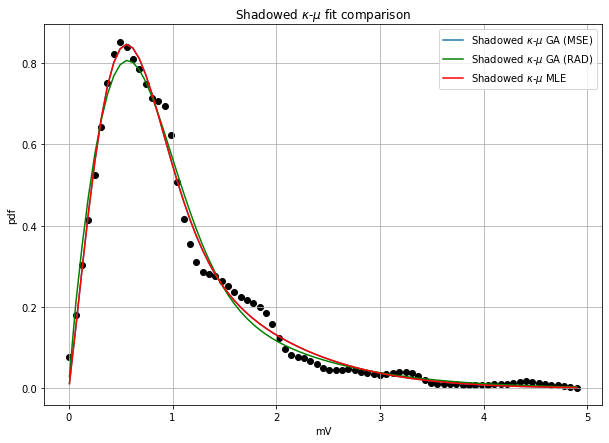

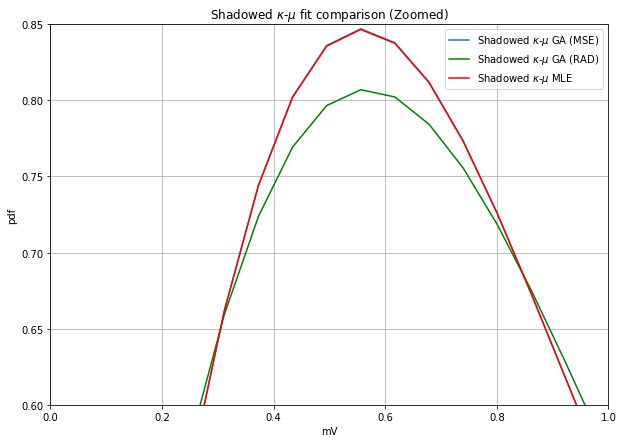

In [43]:
plt.figure(figsize=((10,7)))
plt.scatter(Xdata, Ydata, c='black')
plt.plot(Xdata, shadowedKappaMuPDF(Xdata, kappa_hat_sku, mu_hat_sku, omega_hat_sku, md_hat_sku), label='Shadowed $\kappa$-$\mu$ GA (MSE)')
plt.plot(Xdata, shadowedKappaMuPDF(Xdata, kappa_hat_sku_rad, mu_hat_sku_rad, omega_hat_sku_rad, md_hat_sku_rad), label='Shadowed $\kappa$-$\mu$ GA (RAD)', c='green')
plt.plot(Xdata, shadowed_k_u_pdf, label='Shadowed $\kappa$-$\mu$ MLE', c='red')
plt.title(f'Shadowed $\kappa$-$\mu$ fit comparison')
plt.legend()
plt.grid(True)
plt.xlabel(r'mV')
plt.ylabel('pdf')
plt.show()

plt.figure(figsize=((10,7)))
plt.plot(Xdata, shadowedKappaMuPDF(Xdata, kappa_hat_sku, mu_hat_sku, omega_hat_sku, md_hat_sku), label='Shadowed $\kappa$-$\mu$ GA (MSE)')
plt.plot(Xdata, shadowedKappaMuPDF(Xdata, kappa_hat_sku_rad, mu_hat_sku_rad, omega_hat_sku_rad, md_hat_sku_rad), label='Shadowed $\kappa$-$\mu$ GA (RAD)', c='green')
plt.plot(Xdata, shadowed_k_u_pdf, label='Shadowed $\kappa$-$\mu$ MLE', c='red')
plt.title(f'Shadowed $\kappa$-$\mu$ fit comparison (Zoomed)')
plt.legend()
plt.grid(True)
plt.xlabel(r'mV')
plt.ylabel('pdf')
plt.ylim([.6, .85])
plt.xlim([0, 1])
plt.show()

### RAD/AIC Scores

In [39]:
# Scores - RAD
pVec1 = Ydata/np.sum(Ydata)
pVec2 = shadowedKappaMuPDF(Xdata, kappa_hat_sku, mu_hat_sku, omega_hat_sku, md_hat_sku)\
/np.sum(shadowedKappaMuPDF(Xdata, kappa_hat_sku, mu_hat_sku, omega_hat_sku, md_hat_sku))
KLD_1 = kldiv(pVec1, pVec2)
KLD_2 = kldiv(pVec2, pVec1)
rad_ga_mse_sku = RAD(KLD_1, KLD_2)

pVec1 = Ydata/np.sum(Ydata)
pVec2 = shadowedKappaMuPDF(Xdata, kappa_hat_sku_rad, mu_hat_sku_rad, omega_hat_sku_rad, md_hat_sku_rad)\
/np.sum(shadowedKappaMuPDF(Xdata, kappa_hat_sku_rad, mu_hat_sku_rad, omega_hat_sku_rad, md_hat_sku_rad))
KLD_1 = kldiv(pVec1, pVec2)
KLD_2 = kldiv(pVec2, pVec1)
rad_ga_rad_sku = RAD(KLD_1, KLD_2)

## AIC Analysis

n = len(data_mV)
K = 3

# AIC MLE - KAPPA MU
sum = np.sum(np.log(computePDF(data_mV, mle_kappa_mu[0], mle_kappa_mu[1], mle_kappa_mu[2])))
AIC_mle_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

# AIC MLE - SHADOWED KAPPA MU
sum = np.sum(np.log(shadowedKappaMuPDF(data_mV, mle_shadowed_kappa_mu[0], mle_shadowed_kappa_mu[1], mle_shadowed_kappa_mu[2], mle_shadowed_kappa_mu[3])))
AIC_mle_shadowed_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

# AIC GENETIC ALGORITHM SHADOWED KAPPA MU - FITNESS: MSE
sum = np.sum(np.log(shadowedKappaMuPDF(data_mV, kappa_hat_sku, mu_hat_sku, omega_hat_sku, md_hat_sku)))
AIC_ga_shadowed_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

# AIC GENETIC ALGORITHM SHADOWED KAPPA MU - FITNESS: RAD
sum = np.sum(np.log(shadowedKappaMuPDF(data_mV, kappa_hat_sku_rad, mu_hat_sku_rad, omega_hat_sku_rad, md_hat_sku_rad)))
AIC_ga_shadowed_kappa_mu_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

# AIC GENETIC ALGORITHM - FITNESS: MSE
sum = np.sum(np.log(computePDF(data_mV, kappa_hat, mu_hat, omega_hat)))
AIC_ga_mse = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)
  
# AIC GENETIC ALGORITHM - FITNESS: RAD
sum = np.sum(np.log(computePDF(data_mV, kappa_hat_rad, mu_hat_rad, omega_hat_rad)))
AIC_ga_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

rads = {'Methods':['Genetic Algorithm - KappaMu (Fitness = MSE)', 'Genetic Algorithm - KappaMu (Fitness = RAD)',\
                   'Maximum Likelihood Estimator - KappaMu', 'Maximum Likelihood Estimator - Shadowed KappaMu',\
                   'Genetic Algorithm - Shadowed KappaMu (MSE)', 'Genetic Algorithm - Shadowed KappaMu (RAD)'],
		'Resistor Average Distance':[rad_mse, rad_rad, rad_mle_kappa_mu, rad_mle_shadowed_kappa_mu, rad_ga_mse_sku, rad_ga_rad_sku],
    'Akaike Information Criteria':[AIC_ga_mse[0], AIC_ga_rad[0], AIC_mle_kappa_mu[0], AIC_mle_shadowed_kappa_mu[0], AIC_ga_shadowed_kappa_mu[0], AIC_ga_shadowed_kappa_mu_rad[0]]}

# Create DataFrame
df = pd.DataFrame(rads)
display(df.sort_values(by='Akaike Information Criteria').reset_index(drop=True))

,Methods,Resistor Average Distance,Akaike Information Criteria
0,Maximum Likelihood Estimator - Shadowed KappaMu,0.009950,313225.159357
1,Genetic Algorithm - Shadowed KappaMu (MSE),0.009968,313228.553747
2,Genetic Algorithm - Shadowed KappaMu (RAD),0.008234,313546.321429
3,Genetic Algorithm - KappaMu (Fitness = RAD),0.045994,339767.607016
4,Maximum Likelihood Estimator - KappaMu,0.069296,380914.753628
5,Genetic Algorithm - KappaMu (Fitness = MSE),0.069476,381235.211642
